In [1]:
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
from torch.utils.data import Dataset, DataLoader
from collections import Counter

from torch.optim.lr_scheduler import LambdaLR

import spacy
from typing import List

# Load Train data

In [2]:
# # Uncomment khi chua train sp
# import sentencepiece as spm
# import os

# # 1. Đường dẫn file gốc
# file_en_path = "/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi/train.en.txt"
# file_vi_path = "/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi/train.vi.txt"

# # Kiểm tra xem file có thật sự tồn tại và có dữ liệu không
# if os.path.getsize(file_en_path) == 0 or os.path.getsize(file_vi_path) == 0:
#     raise ValueError("Lỗi: File dữ liệu đầu vào bị rỗng hoặc không tồn tại!")

# # 2. Train SentencePiece trực tiếp (Không cần gộp file thủ công)
# # SentencePiece cho phép truyền danh sách file cách nhau bằng dấu phẩy
# input_arg = f"{file_en_path},{file_vi_path}"

# print(f"Đang train SentencePiece trên: {input_arg}")

# spm.SentencePieceTrainer.train(
#     input=input_arg,             # Truyền trực tiếp danh sách file
#     model_prefix="spm_en_vi",
#     vocab_size=16000,
#     model_type="bpe",
    
#     # --- CÁC THAM SỐ FIX LỖI TREO ---
#     character_coverage=0.9995,   # QUAN TRỌNG: Giảm xuống 0.9995 để bỏ qua ký tự rác gây treo
#     input_sentence_size=1000000, # Lấy mẫu 1 triệu câu
#     shuffle_input_sentence=True,
#     max_sentence_length=4096,
#     num_threads=4,               # Kaggle hỗ trợ 4 threads
#     # --------------------------------
    
#     pad_id=0,
#     unk_id=1,
#     bos_id=2,
#     eos_id=3,
    
#     # Tắt check ký tự quá khắt khe để tránh lỗi runtime
#     # hard_vote_limit=False 
# )

# print("Training complete! File spm_en_vi.model đã được tạo.")

# # 3. Test thử load model xem ngon chưa
# sp = spm.SentencePieceProcessor()
# sp.load("spm_en_vi.model")
# print("Test encode:", sp.encode_as_pieces("Hello Vietnam"))

In [3]:
import sentencepiece as spm
import os

# 1. Đường dẫn file model (File này phải đang nằm trong thư mục làm việc)
model_file = "spm_en_vi.model"

# Kiểm tra xem file có tồn tại không
if not os.path.exists(model_file):
    print(f"⚠️ LỖI: Không tìm thấy file '{model_file}'!")
    print("Nếu bạn vừa Restart Session, hãy kiểm tra lại xem file có bị mất không.")
    print("Nếu file nằm ở thư mục input, hãy sửa lại đường dẫn.")
else:
    # 2. Load model
    sp = spm.SentencePieceProcessor()
    sp.load(model_file)
    print(">>> Đã load Tokenizer thành công!")

    print(f"Kích thước Vocab: {sp.get_piece_size()}")

    # 5. Test thử
    text_test = "Hello Vietnam"
    print(f"Test encode '{text_test}': {sp.encode_as_ids(text_test)}")
    print(f"Test decode: {sp.decode(sp.encode_as_ids(text_test))}")

>>> Đã load Tokenizer thành công!
Kích thước Vocab: 16000
Test encode 'Hello Vietnam': [11183, 9082]
Test decode: Hello Vietnam


In [4]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

# 1. Load lại Tokenizer đã train ở cell trước
sp = spm.SentencePieceProcessor()
sp.load("spm_en_vi.model")

# Định nghĩa các ID đặc biệt khớp với lúc train SentencePiece
PAD_ID = 0
UNK_ID = 1
BOS_ID = 2
EOS_ID = 3

class IWSLTDataset(Dataset):
    def __init__(self, src_file, tgt_file):
        self.src_lines = []
        self.tgt_lines = []
        
        print("Đang đọc và lọc dữ liệu...")
        with open(src_file, 'r', encoding='utf-8') as fs, \
             open(tgt_file, 'r', encoding='utf-8') as ft:
            
            # Dùng zip để đọc song song 2 file cùng lúc
            # Nếu 2 file lệch dòng gốc, zip sẽ tự dừng ở file ngắn hơn -> Tránh crash
            for s_line, t_line in zip(fs, ft):
                s_clean = s_line.strip()
                t_clean = t_line.strip()
                
                # Logic quan trọng: Chỉ lấy khi CẢ 2 đều có dữ liệu
                if s_clean and t_clean:
                    self.src_lines.append(s_clean)
                    self.tgt_lines.append(t_clean)
        
        print(f"Hoàn tất load data. Số cặp câu hợp lệ: {len(self.src_lines)}")

    def __len__(self):
        return len(self.src_lines)

    def __getitem__(self, idx):
        return self.src_lines[idx], self.tgt_lines[idx]


def collate_batch(batch):
    """
    Hàm này xử lý một batch dữ liệu:
    1. Tokenize text thành list of IDs.
    2. Thêm BOS (Start) và EOS (End) tokens.
    3. Pad (điền số 0) để các câu có độ dài bằng nhau.
    """
    src_batch, tgt_batch = [], []
    
    for src_text, tgt_text in batch:
        # Tokenize và thêm BOS/EOS
        src_ids = [BOS_ID] + sp.encode_as_ids(src_text) + [EOS_ID]
        tgt_ids = [BOS_ID] + sp.encode_as_ids(tgt_text) + [EOS_ID]
        
        src_batch.append(torch.tensor(src_ids, dtype=torch.long))
        tgt_batch.append(torch.tensor(tgt_ids, dtype=torch.long))
    
    # Pad sequence: tạo tensor hình chữ nhật (Batch_Size, Max_Len)
    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=PAD_ID)
    tgt_padded = pad_sequence(tgt_batch, batch_first=True, padding_value=PAD_ID)
    
    return src_padded, tgt_padded

# --- CẤU HÌNH VÀ TẠO DATALOADER ---

# Đường dẫn file (sử dụng file bạn đã tạo ra ở cell đầu tiên)
train_src_file = "/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi/train.en.txt"
train_tgt_file = "/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi/train.vi.txt"

# Tạo Dataset
train_dataset = IWSLTDataset(train_src_file, train_tgt_file)

# Tạo DataLoader
BATCH_SIZE = 16 # Bạn có thể giảm xuống 16 nếu bị tràn RAM (OOM)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,          # Xáo trộn dữ liệu mỗi epoch
    collate_fn=collate_batch, # Sử dụng hàm xử lý batch tuỳ chỉnh
    num_workers=2,         # Tăng tốc độ load dữ liệu (nếu chạy trên Colab/Kaggle)
    pin_memory=True        # Tối ưu khi đẩy sang GPU
)

print(f"Đã tạo DataLoader với {len(train_dataset)} cặp câu.")
print(f"Số lượng batch mỗi epoch: {len(train_dataloader)}")

Đang đọc và lọc dữ liệu...
Hoàn tất load data. Số cặp câu hợp lệ: 133166
Đã tạo DataLoader với 133166 cặp câu.
Số lượng batch mỗi epoch: 8323


# Xây dựng Kiến trúc Transformer

In [5]:
import copy
# clone helper
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [6]:
def attention(query, key, value, mask= None, dropout= None):
    """
    query, key, value: (batch_size x heads x seq_len x d_k )
    mask: ?
    dropout: nn.Dropout module from whichever module using this function
    returns attention output (batch_size x heads x seq_len x d_k)
      and weights
    """

    d_k = query.size(-1) # get head size
    # score = query x key_transpose/ head_size
    score = torch.matmul(query, key.transpose(-2, -1) / math.sqrt(d_k))

    if mask is not None:
        score = score.masked_fill(mask == 0, float('-inf')) # big negative

    # softmax to probabilities
    score = nn.functional.softmax(score, dim = -1)

    if dropout is not None:
        score = dropout(score)
    output = torch.matmul(score, value) # (seq_len x seq_len) @ (seq_len x d_model), no transpose :)
    return output, score # don't really need score

In [7]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [8]:
class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, dim, base=10000):
        super().__init__()
        self.dim = dim
        self.base = base
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, seq_len, *, device=None, dtype=None):
        if device is None:
            device = self.inv_freq.device
        t = torch.arange(seq_len, device=device, dtype=dtype)
        freqs = torch.einsum('i,j->ij', t, self.inv_freq)
        # Complex numbers for rotation
        emb = torch.cat((freqs, freqs), dim=-1)
        return emb.cos(), emb.sin()

def apply_rotary_pos_emb(q, k, freqs):
    # freqs contains (cos, sin) values
    cos, sin = freqs

    # Reshape cos and sin for broadcasting: (1, 1, seq_len, dim)
    # q, k shape: (batch_size, num_heads, seq_len, dim_per_head)
    cos = cos.unsqueeze(0).unsqueeze(0)
    sin = sin.unsqueeze(0).unsqueeze(0)

    # Apply rotation to query and key using complex number multiplication equivalent
    # [x0, x1, x2, x3, ...] -> [x0*cos - x1*sin, x0*sin + x1*cos, x2*cos - x3*sin, ...]
    q_rot = q * cos - rotate_half(q) * sin
    k_rot = k * cos - rotate_half(k) * sin

    return q_rot, k_rot

def rotate_half(x):
    # Rotates the second half of the embedding dimension by 180 degrees.
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)

In [9]:
class MultiHeadedAttention(nn.Module):
  # d_model = embedding dimensions
  def __init__(self, h, d_model, dropout=0.1):
    super(MultiHeadedAttention, self).__init__()
    assert d_model % h == 0
    self.d_k = d_model // h
    self.h = h
    self.linears = get_clones(nn.Linear(d_model, d_model), 4)
    self.attn = None
    self.dropout = nn.Dropout(p=dropout)
    # self.rotary = rotary # Store the RoPE instance

  def forward(self, query, key, value, mask= None):
    """
    q,k,v: batch_size x seq_length x d_model
    mask?
    output: batch_size x seq_length x d_model
    """
    if mask is not None:
      # Same mask applied to all h heads.
      mask = mask.unsqueeze(1)

    nbatches = query.size(0)

    query, key, value = [
        lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        for lin, x in zip(self.linears, (query, key, value))
    ]
    # Apply attention on all the projected vectors in batch.
    x, self.attn = attention(
        query, key, value, mask=mask, dropout=self.dropout
    )

    #  "Concat" using a view and apply a final linear.
    x = (
        x.transpose(1, 2)
        .contiguous()
        .view(nbatches, -1, self.h * self.d_k)
    )
    del query
    del key
    del value
    return self.linears[-1](x)

In [10]:
# embedding before encoder
# lut = lookup table, x is the tensor to look up
#
class Embedding(nn.Module):
  def __init__(self, d_model, vocab):
    super(Embedding, self).__init__()
    self.lut = nn.Embedding(vocab, d_model)
    self.d_model = d_model
  def forward(self, x):
    return self.lut(x) * math.sqrt(self.d_model) # why???

In [11]:
class LayerNorm(nn.Module):
    # implement layer normalization
    # eps for numerical stability
    def __init__(self, features, eps=1e-6):
      super(LayerNorm, self).__init__()
      self.a_2 = nn.Parameter(torch.ones(features))
      self.b_2 = nn.Parameter(torch.zeros(features))
      self.eps = eps
    def forward(self, x):
      mean = x.mean(-1, keepdim=True)
      std = x.std(-1, keepdim=True)
      return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


In [12]:
class SublayerConnection(nn.Module):
  # residual + norm
  # norm before or after? before!
  """ connect sub layers """
  def __init__(self, size, dropout):
    super(SublayerConnection, self).__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, sublayer):
    return x + self.dropout(sublayer(self.norm(x)))

In [13]:
class PositionwiseFeedForward(nn.Module):
  # add non-linearities to attention
  # just two linear transformation with an activation (ReLU)
  # we can try using something else like SiLU, but can we justify it?
  def __init__(self, d_model, d_ff, dropout=0.1):
    super(PositionwiseFeedForward, self).__init__()
    self.w_1 = nn.Linear(d_model, d_ff)
    self.w_2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(dropout)
  def forward(self, x):
    return self.w_2(self.dropout(self.w_1(x).relu()))

In [14]:
class Encoder(nn.Module):
    # nn.Module là lớp cơ sở cho tất cả các mạng neural trong PyTorch
    """multiple stacked layers of EncoderLayer"""
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = get_clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [15]:
class EncoderLayer(nn.Module):
  """a layer of encoder"""
  """self attention then ffw"""
  # size = d_model
  # x is input?
  def __init__(self, size, self_attn, ffw, dropout):
    super(EncoderLayer, self).__init__()
    self.self_attn = self_attn
    self.ffw = ffw
    self.sublayer = get_clones(SublayerConnection(size, dropout), 2)
    self.size = size
  def forward(self, x, mask):
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) # q,k,v is the same!
    return self.sublayer[1](x, lambda x: self.ffw(x))


In [16]:
class DecoderLayer(nn.Module):
  # self-explanatory
  # needs mask for self-attention
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = get_clones(SublayerConnection(size, dropout), 3)
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, memory, memory, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [17]:
# mask helper
def subsequent_mask(size):
    "Mask out future positions"
    return torch.tril(torch.ones(size, size, dtype=torch.bool)).unsqueeze(0)

In [18]:
class Decoder(nn.Module):
  # cũng nhiều lớp decoder xếp chồng lên nhau
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = get_clones(layer, N)
        self.norm = LayerNorm(layer.size)
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [19]:
class EncoderDecoder(nn.Module):
    """
    wrap the things together
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [20]:
class Generator(nn.Module):
  """final linear + softmax step"""
  def __init__(self, d_model, vocab):
      super(Generator, self).__init__()
      self.proj = nn.Linear(d_model, vocab)
  def forward(self, x):
      return nn.functional.log_softmax(self.proj(x), dim=-1)

# Huấn luyện và Đánh giá

In [21]:
class Batch:
    def __init__(self, src, tgt=None, pad=PAD_ID):  # 2 = <blank>
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    # hide the PADDING too
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask

In [22]:
def make_model(src_vocab, tgt_vocab, layers , h, d_model , d_ff , dropout = 0.1):
  # just make a model :)
  c = copy.deepcopy
  # rotary_pe = RotaryPositionalEmbedding(d_model // h)
  attn = MultiHeadedAttention(h, d_model) # Pass rotary_pe to attention
  ff = PositionwiseFeedForward(d_model, d_ff, dropout)
  position = PositionalEncoding(d_model, dropout)
  model = EncoderDecoder(
    Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), layers),
    Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), layers),
    nn.Sequential(Embedding(d_model, src_vocab),c(position)),
    nn.Sequential(Embedding(d_model, tgt_vocab),c(position)),
    Generator(d_model, tgt_vocab),
  )
  for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
  return model

In [23]:
# used in inference
def beam_search(model, memory, src_mask, start_symbol, end_symbol, max_len=100, beam_size=5, device='cpu'):
    # memory: output of the encoder
    # src_mask: source mask
    # start_symbol: token for <s>
    # end_symbol: token for </s>
    # max_len: maximum length of generated sequence
    # beam_size: number of candidates to keep at each step

    # Ensure the model is in evaluation mode
    model.eval()

    # Initialize with the start symbol
    ys = torch.full((1, 1), start_symbol, dtype=torch.long, device=device)

    # Store (log_probability, sequence_so_far)
    candidates = [(0.0, ys)]

    for _ in range(max_len - 1):
        new_candidates = []
        # Iterate through current best candidates
        for log_prob, current_sequence in candidates:

            # If the sequence already ended, keep it as is
            if current_sequence[0, -1].item() == end_symbol:
                new_candidates.append((log_prob, current_sequence))
                continue

            # Create target mask for the current sequence
            tgt_mask = subsequent_mask(current_sequence.size(-1)).type_as(memory)

            # Decode the next token
            out = model.decode(memory, src_mask, current_sequence, tgt_mask)
            prob = model.generator(out[:, -1]) # Get probabilities for the last token
            log_probs = prob.log_softmax(dim=-1) # Convert to log probabilities

            # Get top 'beam_size' next tokens and their log probabilities
            top_k_log_probs, top_k_indices = log_probs.topk(beam_size)

            for i in range(beam_size):
                next_token_log_prob = top_k_log_probs[0, i].item()
                next_token = top_k_indices[0, i].item()

                # Extend the current sequence with the new token
                extended_sequence = torch.cat(
                    [current_sequence, torch.full((1, 1), next_token, dtype=torch.long, device=device)], dim=1
                )
                new_candidates.append((log_prob + next_token_log_prob, extended_sequence))

        # Sort all new candidates by their log probability and select the top 'beam_size'
        candidates = sorted(new_candidates, key=lambda x: x[0], reverse=True)[:beam_size]

        # If all best candidates have ended, we can stop early (optional optimization)
        if all(cand[1][0, -1].item() == end_symbol for cand in candidates):
            break

    # Return the best sequence (highest log probability)
    return candidates[0][1].cpu().squeeze().tolist()


In [24]:
def rate(step, d_model, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        d_model ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

In [25]:
#loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, padding_idx = 0, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
        self.padding_idx = padding_idx

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 2))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            true_dist[:, self.padding_idx] = 0
            mask = torch.nonzero(target.data == self.padding_idx, as_tuple=False)
            if mask.dim() > 0:
                true_dist.index_fill_(0, mask.squeeze(), 0.0)

        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [26]:
import os
# 1. Đường dẫn file Validate
val_src_file = "/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi/tst2012.en.txt"
val_tgt_file = "/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi/tst2012.vi.txt"

# 2. Tạo Dataset và DataLoader
# Lưu ý: Batch size cho Val có thể gấp đôi Train vì không cần lưu Gradient (ít tốn RAM hơn)
if os.path.exists(val_src_file):
    val_dataset = IWSLTDataset(val_src_file, val_tgt_file)
    
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=64, # Để 64 cho nhanh, nếu OOM thì giảm xuống 32
        shuffle=False, # Validate không cần shuffle
        collate_fn=collate_batch,
        num_workers=2,
        pin_memory=True
    )
    print(f"Validation DataLoader created. Size: {len(val_dataset)}")
else:
    raise ValueError("Không tìm thấy file tst2012!")

Đang đọc và lọc dữ liệu...
Hoàn tất load data. Số cặp câu hợp lệ: 1553
Validation DataLoader created. Size: 1553


In [27]:
import math

def evaluate_loss(model, val_dataloader, criterion, device, pad_idx = PAD_ID):
    """
    Chạy model trên tập Val để tính Loss và Perplexity
    """
    model.eval() # Chuyển sang chế độ đánh giá (tắt Dropout)
    total_loss = 0
    
    with torch.no_grad(): # Tắt tính toán gradient để tiết kiệm RAM
        for batch_data in val_dataloader:
            src, tgt = batch_data[0].to(device), batch_data[1].to(device)
            batch = Batch(src, tgt, pad=pad_idx)
            
            # Forward pass
            out = model(batch.src, batch.tgt, batch.src_mask, batch.tgt_mask)
            out = model.generator(out)
            
            # Tính Loss
            loss = criterion(out.contiguous().view(-1, out.size(-1)), 
                             batch.tgt_y.contiguous().view(-1))
            total_loss += loss.item()
            
    avg_loss = total_loss / len(val_dataloader)
    
    # Tính Perplexity (PPL) = exp(Loss)
    # PPL càng thấp càng tốt
    try:
        ppl = math.exp(avg_loss)
    except OverflowError:
        ppl = float('inf')
        
    model.train() # Quan trọng: Chuyển lại về chế độ train cho epoch sau
    return avg_loss, ppl

In [28]:
import torch

def translate_sentence(sentence, model, sp_model, device, max_len=100):
    model.eval() # Chuyển sang chế độ đánh giá
    
    # 1. Tokenize câu đầu vào
    # Thêm BOS và EOS giống hệt lúc train
    tokens = [BOS_ID] + sp_model.encode_as_ids(sentence) + [EOS_ID]
    src = torch.tensor(tokens).long().unsqueeze(0).to(device) # (1, seq_len)
    
    # 2. Tạo mask
    src_mask = (src != PAD_ID).unsqueeze(-2)
    
    # 3. Encoder
    with torch.no_grad():
        memory = model.encode(src, src_mask)
        
    # 4. Beam Search (Hàm này bạn đã có trong code gốc)
    # Lưu ý: Cần đảm bảo hàm beam_search đã được định nghĩa
    output_ids = beam_search(model, memory, src_mask, BOS_ID, EOS_ID, max_len, beam_size=3, device=device)
    
    # 5. Decode
    if EOS_ID in output_ids:
        output_ids = output_ids[:output_ids.index(EOS_ID)]
        
    translation = sp_model.decode(output_ids)
    
    model.train() # Chuyển lại về mode train
    return translation

In [29]:
# Thiết lập thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

D_MODEL = 128
VOCAB_SIZE = sp.get_piece_size() 
D_FF = 1024
LAYERS=4
H=4
# Quan trọng: LabelSmoothingLoss cần input đúng kích thước vocab
criterion = LabelSmoothingLoss(classes=VOCAB_SIZE, padding_idx=PAD_ID, smoothing=0.1)

# Khởi tạo mô hình (đảm bảo hàm make_model đã được sửa như mục 3)
model = make_model(src_vocab=VOCAB_SIZE, tgt_vocab=VOCAB_SIZE, 
                   layers=LAYERS, h=H, d_model=D_MODEL, d_ff=D_FF, dropout=0.1)

model.to(device)

print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters.")

Using device: cuda
Model created with 9064576 parameters.


In [30]:
def train_with_validation_and_checkpointing(
    model, train_dataloader, val_dataloader, criterion, optimizer, lr_scheduler, 
    device, pad_idx, sp_model, num_epochs, sample_sentence,
    start_epoch=0, best_val_loss=float('inf')
):
    model.train()
    scaler = torch.amp.GradScaler("cuda")
    print(f"{'='*10} BẮT ĐẦU TRAINING VỚI  {'='*10}")

    # Khởi tạo history để lưu kết quả
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_ppl": []
    }
    print(f"{'='*10} BẮT ĐẦU TRAINING TỪ EPOCH {start_epoch + 1} {'='*10}")
    for epoch in range(start_epoch, num_epochs):
        print(f"\n--- Epoch {epoch + 1}/{num_epochs} ---")
        
        # 1. TRAINING LOOP
        model.train()
        train_loss = 0
        pbar = tqdm(train_dataloader, desc="Training")
        
        for i, batch_data in enumerate(pbar):
            src, tgt = batch_data[0].to(device), batch_data[1].to(device)
            # Skip câu quá dài
            if src.size(1) > 150 or tgt.size(1) > 150: continue
            
            batch = Batch(src, tgt, pad=pad_idx)
            with torch.amp.autocast(device_type="cuda"):
            # with autocast():
                out = model(batch.src, batch.tgt, batch.src_mask, batch.tgt_mask)
                out = model.generator(out)
                loss = criterion(out.contiguous().view(-1, out.size(-1)), batch.tgt_y.contiguous().view(-1))

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            lr_scheduler.step()
            
            train_loss += loss.item()
            pbar.set_postfix({"loss": loss.item(), "lr": optimizer.param_groups[0]["lr"]})
            
        avg_train_loss = train_loss / len(train_dataloader)
        
        # 2. VALIDATION LOOP (Sau khi xong 1 epoch train)
        print("Đang chạy validate...")
        avg_val_loss, val_ppl = evaluate_loss(model, val_dataloader, criterion, device, pad_idx)
        
        print(f"📌 KẾT QUẢ EPOCH {epoch+1}:")
        print(f"   - Train Loss: {avg_train_loss:.4f}")
        print(f"   - Val Loss:   {avg_val_loss:.4f} (Perplexity: {val_ppl:.2f})")
        
        # 1. Lưu checkpoint của epoch cuối cùng (để phòng khi bị crash giữa chừng)
        torch.save({
            'epoch': epoch + 1, # Lưu epoch kế tiếp sẽ chạy
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': lr_scheduler.state_dict(),
            'best_val_loss': best_val_loss,
        }, "last_checkpoint.pth")
        
        # 2. Lưu checkpoint tốt nhất (dựa trên val_loss)
        if avg_val_loss < best_val_loss:
            print(f"✅ Loss giảm ({best_val_loss:.4f} -> {avg_val_loss:.4f}). Lưu best checkpoint!")
            best_val_loss = avg_val_loss
            # Gói tất cả vào một dictionary
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': lr_scheduler.state_dict(),
                'best_val_loss': best_val_loss,
            }, "best_checkpoint.pth")
        else:
            print(f"⚠️ Loss không giảm (Best: {best_val_loss:.4f}). Không cập nhật best checkpoint.")
            
        # Lưu kết quả vào history
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_ppl"].append(val_ppl)
        # 4. Dịch thử
        if sp_model:
            try:
                pred = translate_sentence(sample_sentence, model, sp_model, device)
                print(f"   - Dịch thử: {pred}")
            except: pass
            
    print(f"\nTraining hoàn tất! Best Val Loss: {best_val_loss:.4f}")
    return history

In [31]:
def load_checkpoint(model, optimizer, scheduler, filename="last_checkpoint.pth"):
    start_epoch = 0
    best_val_loss = float('inf')
    
    if os.path.exists(filename):
        print(f"--- Đang tải checkpoint từ: {filename} ---")
        checkpoint = torch.load(filename, map_location=device)
        
        # Khôi phục trạng thái
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        # Lấy thông tin epoch và loss để train tiếp
        start_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_loss']
        
        print(f"✅ Khôi phục thành công! Sẵn sàng train tiếp từ Epoch {start_epoch + 1}.")
        print(f"   - Best Val Loss đã ghi nhận: {best_val_loss:.4f}")
        print(f"   - Learning Rate hiện tại: {optimizer.param_groups[0]['lr']:.6f}")
    else:
        print("--- Không tìm thấy checkpoint. Bắt đầu training từ đầu. ---")
        
    return start_epoch, best_val_loss


In [35]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    """
    Vẽ đồ thị Train Loss, Val Loss, và Val Perplexity.
    """
    # Lấy dữ liệu từ history
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    val_ppl = history['val_ppl']
    epochs = range(1, len(train_loss) + 1)
    
    # Tạo figure với 2 subplot
    plt.figure(figsize=(14, 5))
    
    # --- Biểu đồ 1: Loss ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # --- Biểu đồ 2: Perplexity ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_ppl, 'go-', label='Validation Perplexity')
    plt.title('Validation Perplexity')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

--- Đang tải checkpoint từ: last_checkpoint.pth ---
✅ Khôi phục thành công! Sẵn sàng train tiếp từ Epoch 4.
   - Best Val Loss đã ghi nhận: 1.3710
   - Learning Rate hiện tại: 0.000564
========== BẮT ĐẦU TRAINING VỚI  ==========
========== BẮT ĐẦU TRAINING TỪ EPOCH 4 ==========

--- Epoch 4/20 ---


Training: 100%|██████████| 8323/8323 [07:30<00:00, 18.46it/s, loss=1.92, lr=0.000489] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 4:
   - Train Loss: 1.5436
   - Val Loss:   1.2970 (Perplexity: 3.66)
✅ Loss giảm (1.3710 -> 1.2970). Lưu best checkpoint!
   - Dịch thử: Cảm ơn rất nhiều thời gian của bạn .

--- Epoch 5/20 ---


Training: 100%|██████████| 8323/8323 [07:30<00:00, 18.49it/s, loss=1.32, lr=0.000437] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 5:
   - Train Loss: 1.5028
   - Val Loss:   1.2803 (Perplexity: 3.60)
✅ Loss giảm (1.2970 -> 1.2803). Lưu best checkpoint!
   - Dịch thử: Cảm ơn các bạn rất nhiều lần .

--- Epoch 6/20 ---


Training: 100%|██████████| 8323/8323 [07:49<00:00, 17.74it/s, loss=1.38, lr=0.000399] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 6:
   - Train Loss: 1.4761
   - Val Loss:   1.2654 (Perplexity: 3.54)
✅ Loss giảm (1.2803 -> 1.2654). Lưu best checkpoint!
   - Dịch thử: Cảm ơn các bạn rất nhiều thời gian .

--- Epoch 7/20 ---


Training: 100%|██████████| 8323/8323 [07:44<00:00, 17.92it/s, loss=1.21, lr=0.000369] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 7:
   - Train Loss: 1.4566
   - Val Loss:   1.2556 (Perplexity: 3.51)
✅ Loss giảm (1.2654 -> 1.2556). Lưu best checkpoint!
   - Dịch thử: Cảm ơn các bạn rất nhiều thời gian .

--- Epoch 8/20 ---


Training: 100%|██████████| 8323/8323 [07:36<00:00, 18.22it/s, loss=1.77, lr=0.000345] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 8:
   - Train Loss: 1.4376
   - Val Loss:   1.2484 (Perplexity: 3.48)
✅ Loss giảm (1.2556 -> 1.2484). Lưu best checkpoint!
   - Dịch thử: Cảm ơn rất nhiều thời gian của bạn .

--- Epoch 9/20 ---


Training: 100%|██████████| 8323/8323 [07:29<00:00, 18.52it/s, loss=1.54, lr=0.000326] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 9:
   - Train Loss: 1.4284
   - Val Loss:   1.2403 (Perplexity: 3.46)
✅ Loss giảm (1.2484 -> 1.2403). Lưu best checkpoint!
   - Dịch thử: Cảm ơn các bạn rất nhiều về thời gian .

--- Epoch 10/20 ---


Training: 100%|██████████| 8323/8323 [07:25<00:00, 18.70it/s, loss=1.91, lr=0.000309] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 10:
   - Train Loss: 1.4154
   - Val Loss:   1.2353 (Perplexity: 3.44)
✅ Loss giảm (1.2403 -> 1.2353). Lưu best checkpoint!
   - Dịch thử: Cảm ơn các bạn rất nhiều .

--- Epoch 11/20 ---


Training: 100%|██████████| 8323/8323 [07:25<00:00, 18.68it/s, loss=1.31, lr=0.000295] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 11:
   - Train Loss: 1.4042
   - Val Loss:   1.2290 (Perplexity: 3.42)
✅ Loss giảm (1.2353 -> 1.2290). Lưu best checkpoint!
   - Dịch thử: Cảm ơn các bạn rất nhiều thời gian .

--- Epoch 12/20 ---


Training: 100%|██████████| 8323/8323 [07:28<00:00, 18.58it/s, loss=1.29, lr=0.000282] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 12:
   - Train Loss: 1.3984
   - Val Loss:   1.2261 (Perplexity: 3.41)
✅ Loss giảm (1.2290 -> 1.2261). Lưu best checkpoint!
   - Dịch thử: Cảm ơn các bạn rất nhiều thời gian .

--- Epoch 13/20 ---


Training: 100%|██████████| 8323/8323 [07:56<00:00, 17.45it/s, loss=1.26, lr=0.000271] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 13:
   - Train Loss: 1.3924
   - Val Loss:   1.2206 (Perplexity: 3.39)
✅ Loss giảm (1.2261 -> 1.2206). Lưu best checkpoint!
   - Dịch thử: Cảm ơn các bạn rất nhiều thời gian .

--- Epoch 14/20 ---


Training: 100%|██████████| 8323/8323 [08:01<00:00, 17.29it/s, loss=1.67, lr=0.000261] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 14:
   - Train Loss: 1.3791
   - Val Loss:   1.2183 (Perplexity: 3.38)
✅ Loss giảm (1.2206 -> 1.2183). Lưu best checkpoint!
   - Dịch thử: Cảm ơn các bạn rất nhiều thời gian .

--- Epoch 15/20 ---


Training: 100%|██████████| 8323/8323 [07:59<00:00, 17.34it/s, loss=1.79, lr=0.000252] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 15:
   - Train Loss: 1.3734
   - Val Loss:   1.2169 (Perplexity: 3.38)
✅ Loss giảm (1.2183 -> 1.2169). Lưu best checkpoint!
   - Dịch thử:  ⁇ in cảm ơn các bạn rất nhiều .

--- Epoch 16/20 ---


Training: 100%|██████████| 8323/8323 [07:51<00:00, 17.64it/s, loss=1.5, lr=0.000244]  

Đang chạy validate...


📌 KẾT QUẢ EPOCH 16:
   - Train Loss: 1.3681
   - Val Loss:   1.2138 (Perplexity: 3.37)
✅ Loss giảm (1.2169 -> 1.2138). Lưu best checkpoint!
   - Dịch thử: Cảm ơn rất nhiều vì thời gian của bạn .

--- Epoch 17/20 ---


Training: 100%|██████████| 8323/8323 [07:34<00:00, 18.31it/s, loss=0.838, lr=0.000237]

Đang chạy validate...


📌 KẾT QUẢ EPOCH 17:
   - Train Loss: 1.3654
   - Val Loss:   1.2111 (Perplexity: 3.36)
✅ Loss giảm (1.2138 -> 1.2111). Lưu best checkpoint!
   - Dịch thử: Cảm ơn các bạn rất nhiều .

--- Epoch 18/20 ---


Training: 100%|██████████| 8323/8323 [07:40<00:00, 18.06it/s, loss=1.72, lr=0.00023]  

Đang chạy validate...


📌 KẾT QUẢ EPOCH 18:
   - Train Loss: 1.3603
   - Val Loss:   1.2071 (Perplexity: 3.34)
✅ Loss giảm (1.2111 -> 1.2071). Lưu best checkpoint!
   - Dịch thử: Cảm ơn các bạn rất nhiều thời gian của bạn .

--- Epoch 19/20 ---


Training: 100%|██████████| 8323/8323 [07:48<00:00, 17.77it/s, loss=1.25, lr=0.000224] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 19:
   - Train Loss: 1.3568
   - Val Loss:   1.2068 (Perplexity: 3.34)
✅ Loss giảm (1.2071 -> 1.2068). Lưu best checkpoint!
   - Dịch thử: Cảm ơn rất nhiều vì thời gian của bạn .

--- Epoch 20/20 ---


Training: 100%|██████████| 8323/8323 [07:48<00:00, 17.77it/s, loss=1.04, lr=0.000218] 

Đang chạy validate...


📌 KẾT QUẢ EPOCH 20:
   - Train Loss: 1.3482
   - Val Loss:   1.2044 (Perplexity: 3.33)
✅ Loss giảm (1.2068 -> 1.2044). Lưu best checkpoint!
   - Dịch thử: Cảm ơn rất nhiều thời gian của bạn .

Training hoàn tất! Best Val Loss: 1.2044
Training hoàn tất. Đang vẽ đồ thị...


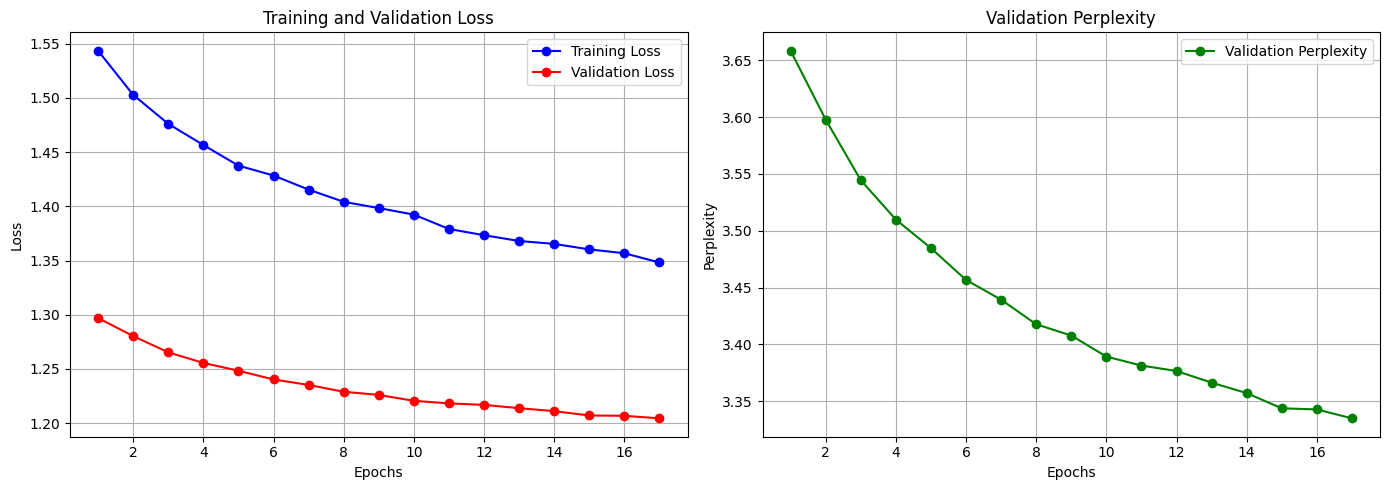

In [39]:
from tqdm import tqdm
optimizer = torch.optim.Adam(model.parameters(), lr=1.0, betas=(0.9, 0.98), eps=1e-9)
lr_scheduler = LambdaLR(optimizer=optimizer,
    lr_lambda=lambda step: rate(step, d_model=D_MODEL, factor=1, warmup=4000))

# --- 2. LOAD CHECKPOINT (NẾU CÓ) ---
# Hàm này sẽ tự động điền trạng thái đã lưu vào các object ở trên
start_epoch, best_val_loss = load_checkpoint(model, optimizer, lr_scheduler)
# Train lại từ đầu hoặc train tiếp 
try:
    history = train_with_validation_and_checkpointing(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        criterion=criterion,
        optimizer=optimizer,         # Truyền optimizer đã được load state
        lr_scheduler=lr_scheduler,   # Truyền scheduler đã được load state
        device=device,
        pad_idx=PAD_ID,
        sp_model=sp,
        num_epochs=20,               # Ví dụ muốn train tổng cộng 20 epochs
        sample_sentence="Thank you very much for your time.",
        start_epoch=start_epoch,     # Bắt đầu từ epoch đã load
        best_val_loss=best_val_loss  # Dùng best_loss đã load để so sánh
    )
except KeyboardInterrupt:
    print("Đã dừng training thủ công.")
finally:
    # 2. Sau khi chạy xong (dù thành công hay thất bại), hãy kiểm tra xem 'history' có giá trị hợp lệ không
    if history is not None:
        print("Training hoàn tất. Đang vẽ đồ thị...")
        plot_metrics(history)
    else:
        print("Không có dữ liệu history để vẽ đồ thị do training không thành công.")

# Test

In [ ]:
%whos

In [43]:
# import torch
# import os
# import pandas as pd  # Dùng pandas để hiển thị bảng cho đẹp

# # 1. Cấu hình Model (Phải khớp 100% với lúc train)
# # Nếu bạn đã đổi config lúc train thì sửa lại ở đây nhé
# real_vocab_size = sp.get_piece_size()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 2. Khởi tạo lại model rỗng
# model_eval = make_model(src_vocab=real_vocab_size, tgt_vocab=real_vocab_size, 
#                         layers=layers, h=h, d_model=d_model, d_ff=d_ff, dropout=0.1)
# model_eval.to(device)

# # 3. Danh sách câu cần soi (Test Set)
# sentences_to_track = [
#     "Thank you very much for your time.",  # Câu "huyền thoại" của bạn
#     "The world is changing very fast.",    # Câu về sự thay đổi
#     "Dickhead.",                           # Câu kinh điển
#     "We need to protect our environment.", # Câu phức tạp hơn chút
#     "Education is important."              # Câu đơn giản
# ]

# # 4. Hàm chạy vòng lặp qua các Epoch
# def compare_epochs(start_ep=1, end_ep=10):
#     results = {sent: [] for sent in sentences_to_track}
#     epochs_found = []

#     print(f"Đang so sánh từ Epoch {start_ep} đến {end_ep}...\n")

#     for epoch in range(start_ep, end_ep + 1):
#         filename = f"transformer_epoch_{epoch}.pth"
        
#         if not os.path.exists(filename):
#             print(f"⚠️ Không tìm thấy file {filename}, bỏ qua.")
#             continue
            
#         # Load weights vào model
#         model_eval.load_state_dict(torch.load(filename, map_location=device))
#         epochs_found.append(f"Ep {epoch}")
        
#         # Dịch từng câu
#         for sent in sentences_to_track:
#             try:
#                 # Dùng hàm translate_sentence bạn đã có
#                 pred = translate_sentence(sent, model_eval, sp, device)
#                 results[sent].append(pred)
#             except:
#                 results[sent].append("Error")

#     return results, epochs_found

# # --- THỰC THI VÀ HIỂN THỊ ---
# comparison_data, cols = compare_epochs(1, 10) # Chỉnh số epoch tùy theo file bạn có

# # Hiển thị kết quả (Gom nhóm theo từng câu để dễ so sánh sự tiến hóa)
# for sent, translations in comparison_data.items():
#     print(f"🔴 SRC: {sent}")
#     print("-" * 60)
#     # Tạo DataFrame nhỏ để hiển thị cho đẹp
#     df = pd.DataFrame(translations, index=cols, columns=["Bản dịch"])
#     print(df)
#     print("\n" + "="*60 + "\n")

In [ ]:
# # Test thử xem Tokenizer xử lý chữ Xin ra sao
# print("Tokenize 'Xin':", sp.encode_as_pieces("Xin"))
# print("Tokenize 'xin':", sp.encode_as_pieces("xin"))
# print("Tokenize 'Xin cảm ơn':", sp.encode_as_pieces("Xin cảm ơn"))

In [40]:
import torch
from torchmetrics.text import BLEUScore
from tqdm import tqdm
import random

def calculate_bleu(model, dataset, sp_model, device, num_samples=100):
    """
    Tính BLEU Score trên một tập mẫu ngẫu nhiên.
    Args:
        num_samples: Số lượng câu muốn test (để 100-200 cho nhanh)
    """
    print(f"Đang tính BLEU score trên {num_samples} câu ngẫu nhiên...")
    
    # 1. Khởi tạo metric
    bleu = BLEUScore(n_gram=4) # Chuẩn BLEU-4
    
    refs = []       # Danh sách câu gốc (Reference)
    preds = []      # Danh sách câu máy dịch (Prediction)
    
    # 2. Lấy mẫu ngẫu nhiên từ dataset
    # Nếu dataset nhỏ hơn num_samples thì lấy hết
    indices = random.sample(range(len(dataset)), min(len(dataset), num_samples))
    
    model.eval()
    
    # 3. Chạy vòng lặp dịch
    for i in tqdm(indices, desc="Translating"):
        src_text = dataset.src_lines[i] # Câu tiếng Anh
        tgt_text = dataset.tgt_lines[i] # Câu tiếng Việt gốc (Đáp án)
        
        try:
            # Dịch
            pred_text = translate_sentence(src_text, model, sp_model, device)
            
            # Lưu lại kết quả
            preds.append(pred_text)
            
            # Lưu ý: BLEU yêu cầu reference là một list các đáp án (vì 1 câu có thể có nhiều cách dịch)
            # Ở đây ta chỉ có 1 đáp án nên để list chứa 1 string
            refs.append([tgt_text]) 
            
        except Exception as e:
            print(f"Lỗi ở index {i}: {e}")
            continue

    # 4. Tính điểm
    score = bleu(preds, refs)
    
    print("\n" + "="*30)
    print(f"KẾT QUẢ BLEU SCORE: {score.item():.4f}")
    print("="*30)
    
    return score.item(), preds, refs

In [42]:
# 1. Đường dẫn file Test (kiểm tra lại trong folder input của bạn xem tên chính xác là gì)
# Thường là tst2012 hoặc tst2013
test_src_file = "/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi/tst2013.en.txt"
test_tgt_file = "/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi/tst2013.vi.txt"

# 2. Tạo Dataset cho tập Test
if os.path.exists(test_src_file):
    print("Đang tạo Test Dataset...")
    test_dataset = IWSLTDataset(test_src_file, test_tgt_file)
    
    # 3. Tính BLEU trên tập Test 
    print("Đang chấm điểm trên tập Test (Dữ liệu lạ)...")
    score_test, _, _ = calculate_bleu(
        model=model, 
        dataset=test_dataset, 
        sp_model=sp, 
        device=device, 
        num_samples=len(test_dataset)
    )
    print(f"Dataset Test size: {len(test_dataset)}")
else:
    print("Không tìm thấy file Test. Bạn hãy kiểm tra lại đường dẫn trong Input.")

Đang tạo Test Dataset...
Đang đọc và lọc dữ liệu...
Hoàn tất load data. Số cặp câu hợp lệ: 1268
Đang chấm điểm trên tập Test (Dữ liệu lạ)...
Đang tính BLEU score trên 1268 câu ngẫu nhiên...


Translating: 100%|██████████| 1268/1268 [14:09<00:00,  1.49it/s]



KẾT QUẢ BLEU SCORE: 0.2579
Dataset Test size: 1268


In [ ]:
# import os

# # Nén toàn bộ file trong working thành output.zip
# os.system("zip -r output.zip .")

# from IPython.display import FileLink
# print("Bấm vào đây để tải trọn bộ (ZIP):")
# FileLink(r'output.zip')

In [ ]:
# os.remove("best_model_iwslt.pth")
